In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import ot

from functions import *
from noisy_graphs import *
from sample_graphs import *
from frank_wolfe import *
from grampa import *
from eigenalign import *
from isorank import *

In [2]:
#G = nx.read_edgelist('./graphs/collaboration_astrophysics')
#A = nx.adjacency_matrix(G).todense()
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [3]:
#Gprime = nx.Graph.copy(G)
#B = nx.adjacency_matrix(Gprime)

# now run your algorithm on (G, Gprime) or on (A, B) !
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [4]:
# G and Gprime are too big (in memory) for computation
# new dataset


n = 50
p = 0.4

A_eq, b_eq =  bistochastic_equality_constraints(n)

G0, G1, A0, A1 = sample_correlated_geometric(n, p, d=3, s=0.9)
Ps = rand_perm_matrix(n)
print(G0)
print(G1)


Graph with 50 nodes and 506 edges
Graph with 50 nodes and 514 edges


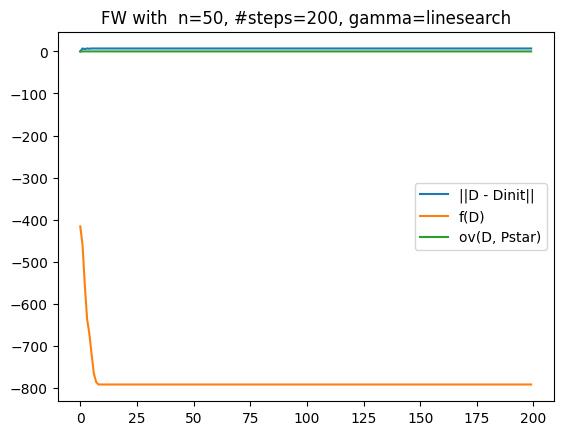

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
#Frank_wolfe algorithm

D = frank_wolfe(A0, A1, 200, Pstar=Ps , method="minustrace",plot=True)
print(D)
# minustrace more efficient than mindiff ??

21.354156504062622


np.float64(0.12)

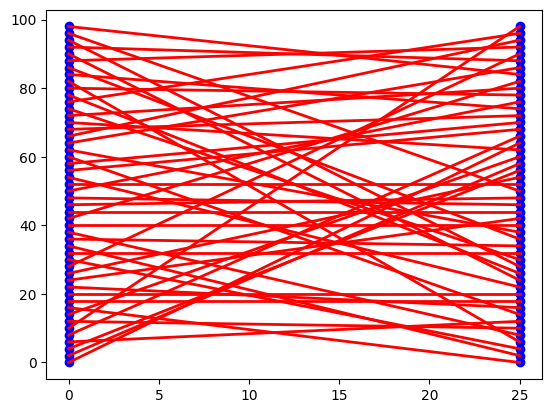

In [6]:
Dp = project_to_perm(D, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D)
print(np.linalg.norm(A0.toarray() - D @ A1.toarray() @ D.T))
overlap(np.eye(n), Dp)

21.354156504062622


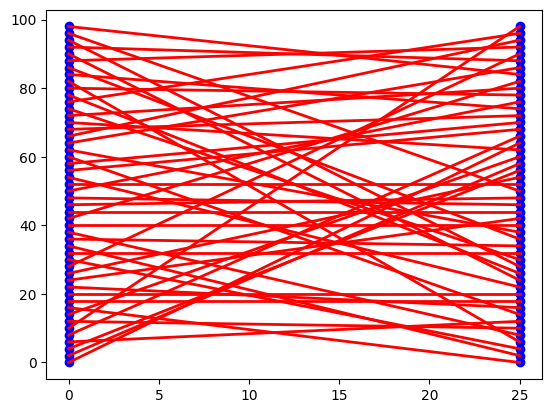

In [7]:
plot_alignment(G0,G1, Dp)
print(np.linalg.norm(A0.toarray() - Dp @ A1.toarray() @ Dp.T))

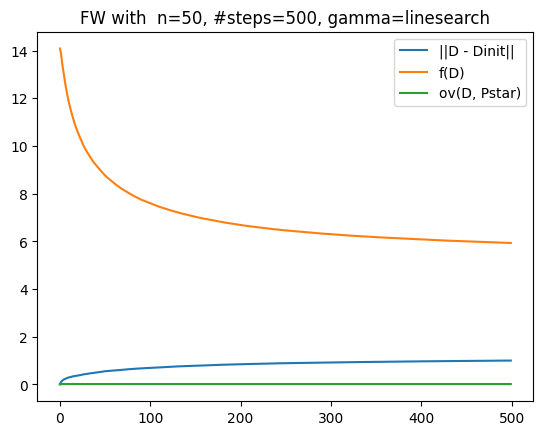

In [8]:
D1 = frank_wolfe(A0, A1, 500, Pstar=Ps , method="mindiff",plot=True)


22.2857231038536


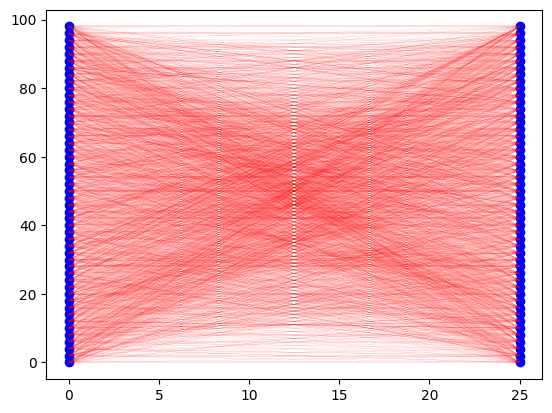

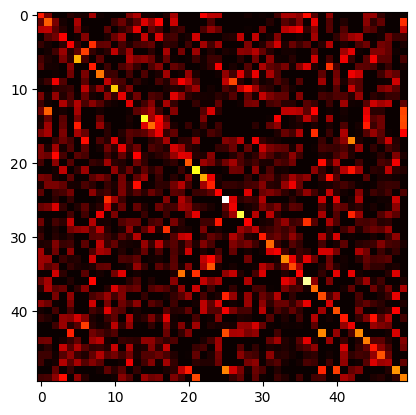

In [9]:
D1p = project_to_perm(D1, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D1)
print(np.linalg.norm(A0.toarray() - D1 @ A1.toarray() @ D1.T))
plt.show()
matrix_heatmap(D1)

13.114877048604


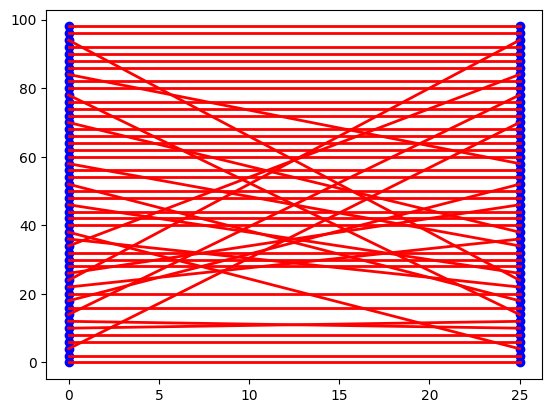

In [10]:
plot_alignment(G0, G1, D1p)
print(np.linalg.norm(A0.toarray() - D1p @ A1.toarray() @ D1p.T))

34.0


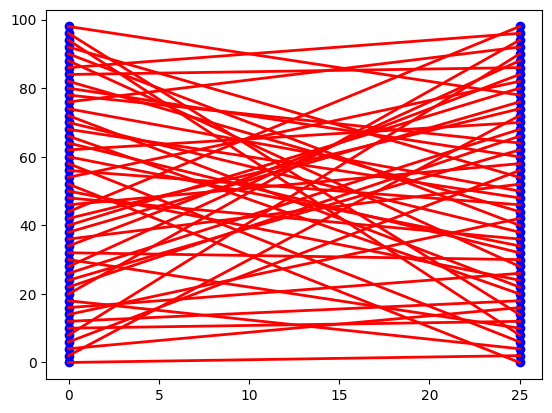

In [11]:
#GRAMPA ?

eta = 0.01
D2 = grampa(A0.toarray(), A1.toarray(), eta)
plot_alignment(G0, G1, D2)
print(np.linalg.norm(A0.toarray() - D2 @ A1.toarray() @ D2.T))

32.863353450309965


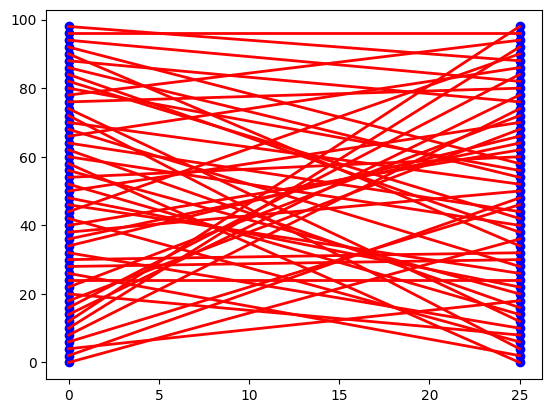

In [12]:
#Better(?) GRAMPA from https://github.com/cheng-mao/grampa/blob/master/grampa.m
D3 = grampa_matlab(A0.toarray(), A1.toarray(), eta)
plot_alignment(G0, G1, D3)
print(np.linalg.norm(A0.toarray() - D3 @ A1.toarray() @ D3.T))

In [13]:
EigP = eigenalign(G0, G1, 1, 0.5, 0.1)

34.23448553724738
0.0


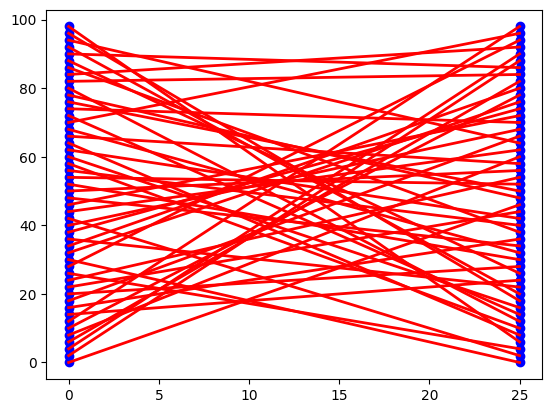

In [14]:
plot_alignment(G0, G1, EigP)
print(np.linalg.norm(A0.toarray() - EigP @ A1.toarray() @ EigP.T))
print(overlap(EigP, np.eye(n)))


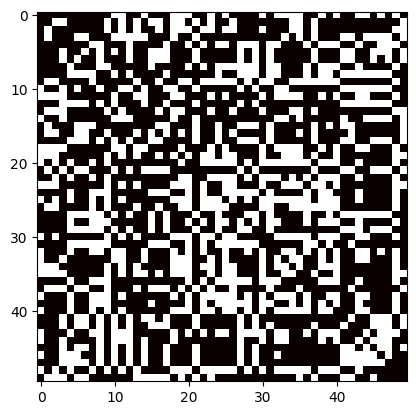

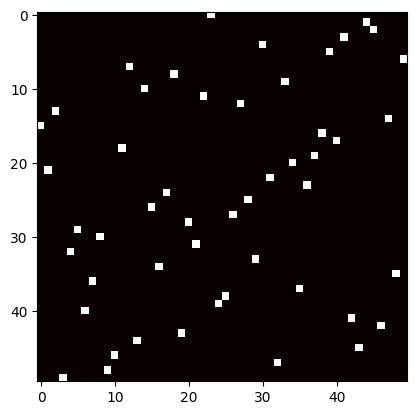

In [15]:
matrix_heatmap(A0.toarray())
plt.plot()
matrix_heatmap(EigP)

33.76388603226827
0.06


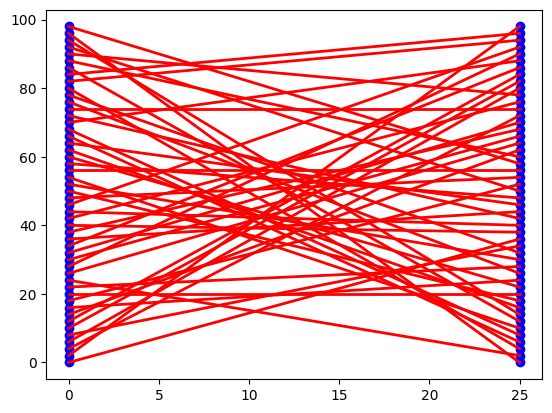

In [16]:
isor = isorank(G0, G1)
plot_alignment(G0, G1, isor)

print(np.linalg.norm(A0.toarray() - isor @ A1.toarray() @ isor.T))
print(overlap(isor, np.eye(n)))



12.165525060596439
0.8


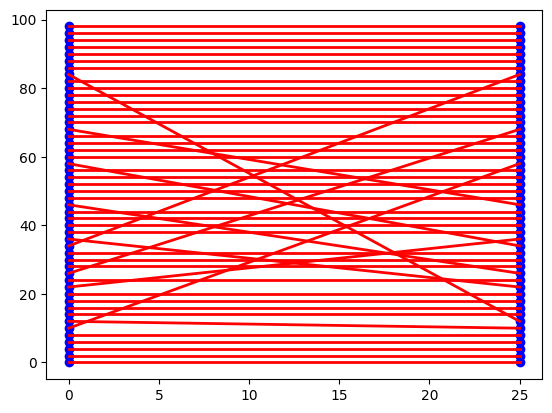

In [35]:
A0 = (A0).astype(float)
A1 = (A1).astype(float)
T = ot.gromov.entropic_gromov_wasserstein(A0.toarray(), A1.toarray(),epsilon=0.1, loss_fun='square_loss')
Tp = project_to_perm(T, A_eq, b_eq)
plot_alignment(G0, G1, Tp)
plt.plot()
print(np.linalg.norm(A0.toarray() - Tp @ A1.toarray() @ Tp.T))
print(overlap(Tp, np.eye(n)))

12.489995996796797
0.74


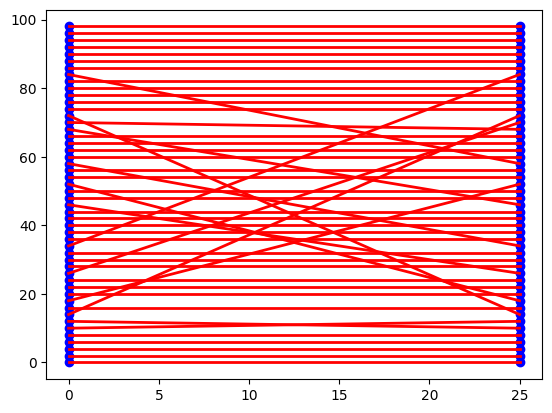

In [18]:
T = greedy_to_perm(T)
print(np.linalg.norm(A0.toarray() - T @ A1.toarray() @ T.T))
print(overlap(T, np.eye(n)))
plot_alignment(G0, G1, T)

12.649110640673518
0.74


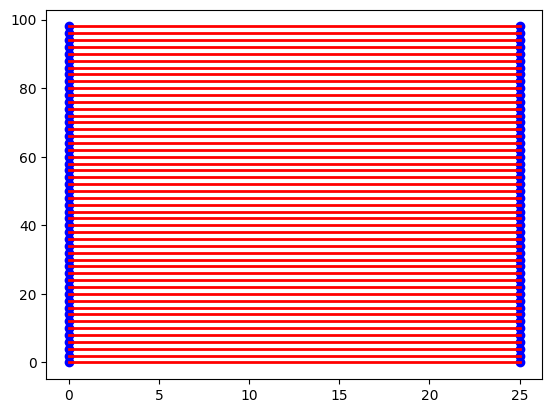

In [19]:
#Identity ?
print(np.linalg.norm(A0.toarray() -  A1.toarray()))
print(overlap(T, np.eye(n)))
plot_alignment(G0, G1, np.eye(n))

In [47]:
#Test on correlated geometric graphs : identity most efficient when very correlated graphs

def normise(L, A, B):
    return np.linalg.norm(A.toarray() - L @ B.toarray() @ L.T)

def construit_liste(n1, n2, p, s):
    x = np.arange(n1, n2, 2)
    Label = ['FWtrace', 'FWmindiff', 'Grampa', 'Grampa_matlab','Isorank', 'Entropic GW', 'id']
    L = []
    for i in x:
        print(i)
        A_eq, b_eq = bistochastic_equality_constraints(i)
        G0, G1, A0, A1 = sample_correlated_geometric(i, p, 3, s)
        Li = []
        Li.append(normise(project_to_perm(frank_wolfe(A0, A1, 200, Pstar=Ps , method="minustrace",plot=False), A_eq, b_eq), A0, A1)) #FW minustrace
        Li.append(normise(project_to_perm(frank_wolfe(A0, A1, 200, Pstar=Ps , method="mindiff",plot=False), A_eq, b_eq), A0, A1)) #FW mindiff
        Li.append(normise(grampa(A0.toarray(), A1.toarray(), eta), A0, A1)) #Grampa
        Li.append(normise(grampa_matlab(A0.toarray(), A1.toarray(), eta), A0, A1)) #Grampa_matlab
        Li.append(normise(isorank(G0, G1), A0, A1))#isorank
        Li.append(normise(project_to_perm(ot.gromov.entropic_gromov_wasserstein(A0.toarray(), A1.toarray(),epsilon=0.1, loss_fun='square_loss'), A_eq, b_eq), A0, A1))#EntropicGW
        Li.append(normise(np.eye(i), A0, A1))
        L.append(Li)
    return L, Label, x

def construit_liste_overlap(n1, n2, p, s):
    x = np.arange(n1, n2, 2)
    Label = ['FWtrace', 'FWmindiff', 'Grampa', 'Grampa_matlab', 'isorank', 'Entropic GW', 'id']
    L = []
    for i in x:
        print(i)
        A_eq, b_eq = bistochastic_equality_constraints(i)
        G0, G1, A0, A1 = sample_correlated_geometric(i, p, 3, s)
        Li = []
        Li.append(overlap(project_to_perm(frank_wolfe(A0, A1, 200, Pstar=Ps , method="minustrace",plot=False), A_eq, b_eq),np.eye(i))) #FW minustrace
        Li.append(overlap(project_to_perm(frank_wolfe(A0, A1, 200, Pstar=Ps , method="mindiff",plot=False), A_eq, b_eq),np.eye(i))) #FW mindiff
        Li.append(overlap(grampa(A0.toarray(), A1.toarray(), eta),np.eye(i))) #Grampa
        Li.append(overlap(grampa_matlab(A0.toarray(), A1.toarray(), eta),np.eye(i))) #Grampa_matlab
        Li.append(overlap(isorank(G0, G1),np.eye(i)))#isorank
        Li.append(overlap(project_to_perm(ot.gromov.entropic_gromov_wasserstein(A0.toarray(), A1.toarray(),epsilon=0.1, loss_fun='square_loss'), A_eq, b_eq),np.eye(i)))#EntropicGW
        Li.append(overlap(np.eye(i), np.eye(i)))
        L.append(Li)
    return L, Label, x


L, Label, x= construit_liste(48, 51, 0.4, 0.9)
Lo, Labelo, x = construit_liste_overlap(48, 51, 0.4, 0.9)

48
50
48
50


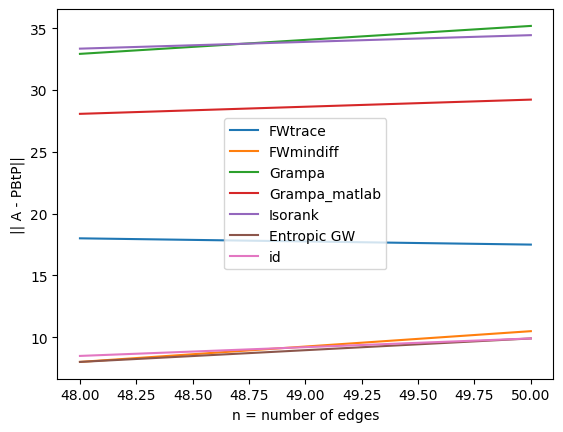

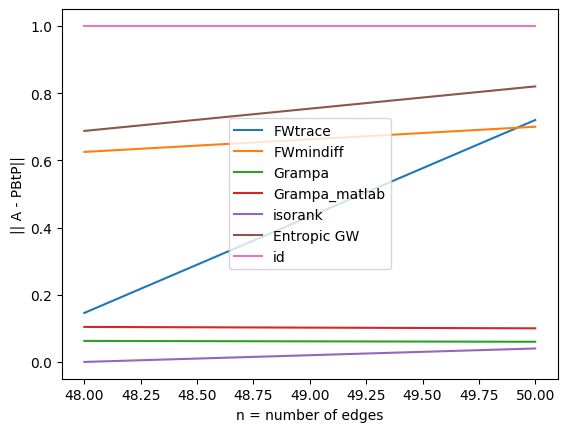

In [48]:
norm_plot(L, Label, x)
plt.show()
norm_plot(Lo, Labelo, x)